## Load and apply inference models
This notebook loads trained inference models from the outputs of `cmass.infer.train`, plots their prediction performance, and applies them to new test data.

In [1]:
import os
from os.path import join
import pickle
import json
import h5py
import matplotlib.pyplot as plt
import numpy as np

In [2]:
wdir = '/anvil/scratch/x-mho1/cmass-ili'
cosmonames = [r'$\Omega_m$', r'$\Omega_b$', r'$h$', r'$n_s$', r'$\sigma_8$']
hodnames = [r'$\alpha$', r'$\log M_0$', r'$\log M_1$',
            r'$\log M_{\min}$', r'$\sigma_{\log M}$']

# Specify model configuration
nbody = 'quijotelike'
sim = 'fastpm'
save_dir = join(wdir, nbody, sim, 'models')

In [3]:
# Specify data dtype
tracer = 'halo'
summaries = ['Pk0']
summary = '+'.join(summaries)
kmax = 0.1
modelpath = join(save_dir, tracer, summary, f'kmax-{kmax}')
os.listdir(modelpath)

['posterior.pkl',
 'loss.jpg',
 'true_logprobs.npy',
 'plot_coverage.jpg',
 'theta_test.npy',
 'x_test.npy',
 'plot_true_logprobs.jpg',
 'ranks_histogram.jpg',
 'plot_single_posterior.jpg',
 'plot_TARP.jpg',
 'summary.json',
 'plot_predictions.jpg',
 'posterior_samples.npy']

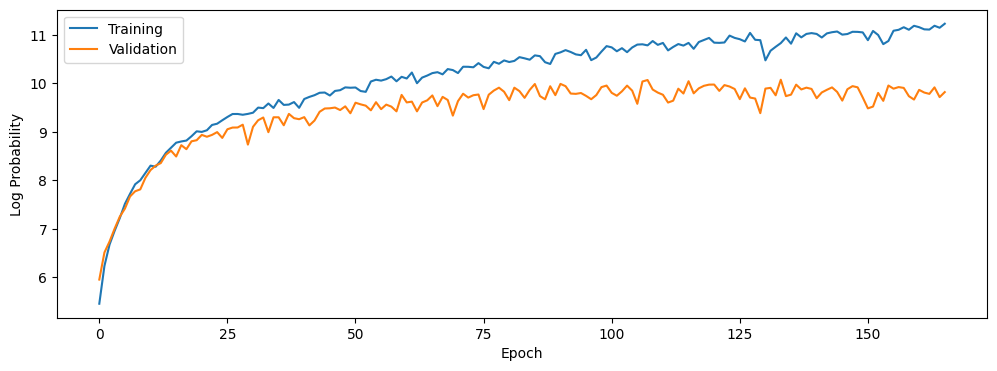

In [4]:
# Load training history
summary_file = join(modelpath, 'summary.json')
with open(summary_file, 'r') as f:
    history = json.load(f)
f, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(history[0]['training_log_probs'], label='Training')
ax.plot(history[0]['validation_log_probs'], label='Validation')
ax.set(xlabel='Epoch', ylabel='Log Probability')
ax.legend()

[Text(0.5, 0, 'True $\\Omega_m$'), Text(0, 0.5, 'Predicted $\\Omega_m$')]

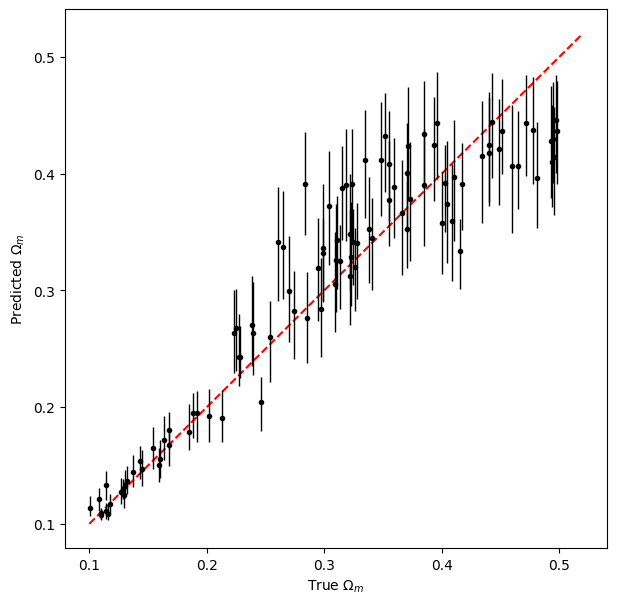

In [5]:
# Load predictions
xtest = np.load(join(modelpath, 'x_test.npy'))
ytest = np.load(join(modelpath, 'theta_test.npy'))
samps = np.load(join(modelpath, 'posterior_samples.npy'))
percs = np.percentile(samps, [16, 50, 84], axis=0)

f, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot([0.1, 0.52], [0.1, 0.52], 'r--')
ax.plot(ytest[:, 0], percs[1, :, 0], 'k.')
ax.errorbar(ytest[:, 0], percs[1, :, 0], yerr=[percs[1, :, 0]-percs[0, :, 0],
            percs[2, :, 0]-percs[1, :, 0]], fmt='none', ecolor='k', elinewidth=1)
ax.set(xlabel=f'True {cosmonames[0]}', ylabel=f'Predicted {cosmonames[0]}')

In [6]:
# Load model posterior
with open(join(modelpath, 'posterior.pkl'), 'rb') as f:
    posterior = pickle.load(f)
# print(posterior)

/anvil/scratch/x-mho1/anaconda3/envs/cmass/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Predict on a test point
samp0 = posterior.sample(x=xtest[10], shape=1000)
plt.scatter(samp0[:, 0], samp0[:, 1], s=1, marker='.')

INFO:root:Sampling models with [1000] samples each.


In [7]:
# Load an observed summary
simpath = join(wdir, 'quijote', 'nbody', 'L1000-N128', '3', 'diag')
a = f'{2/3:.6f}'
with h5py.File(join(simpath, 'halos.h5'), 'r') as f:
    k = f[a]['Pk_k'][:]
    Pk0 = f[a]['Pk'][:, 0]  # get the monopole
summ = {'k': k, 'value': Pk0}

In [8]:
# Preprocess the summary
from cmass.infer.loaders import preprocess_Pk
xin = preprocess_Pk([summ], kmax)[0]

In [ ]:
# Sample the posterior
sampobs = posterior.sample(x=xin, shape=2)